# Facial Keypoints Detection

## Info

# Header

## Import Necessary Packages

In [0]:
# low level
from enum import Enum
import os
import random
from time import time
import datetime
import math

# middle level
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D 

# frameworks
import torch 
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchvision.models import resnet18

## Mout Google Dirve

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data

## Download and Extract Datas

In [0]:
# """Make directory for dataset"""
# !mkdir "/content/drive/My Drive/data"

# """Download Data"""
# os.environ['KAGGLE_USERNAME'] = "" # username from the json file
# os.environ['KAGGLE_KEY'] = "" # key from the json file
# !kaggle datasets download -d  selfishgene/youtube-faces-with-facial-keypoints # api copied from kaggle

# """Extract Data"""
# !unzip /content/youtube-faces-with-facial-keypoints.zip -d "/content/drive/My Drive/data"

## Transformations

### Basics

**Normalization**

In [0]:
class Normalize(object):
    """Normalize the color range to [0,1] and convert a color image to grayscale if needed"""        
    def __init__(self, color = False):
        self.color = color
    
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        if not self.color:
            image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
            
        # scale keypoints to be centered around 0 with a range of [-2, 2]
        key_pts_copy = (key_pts_copy - image.shape[0]/key_pts_copy.shape[1])/(image.shape[0]/key_pts_copy.shape[1]*2)


        return {'image': image_copy, 'keypoints': key_pts_copy}


**Rescale**

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
            
        img = cv2.resize(image, (new_w, new_h))
                 
        # scale the pts, too
        if key_pts.shape[1] == 3:
            key_pts = key_pts * [new_w / w, new_h / h, 1]
        else:
            key_pts = key_pts * [new_w / w, new_h / h]
        
        return {'image': img, 'keypoints': key_pts}

**To Tensor**

In [0]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

### Cropping

**Random Cropping**

In [0]:
class RandomCrop(object):
    """Crop randomly the image in a sample.
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}

**Face Cropping**

In [0]:
class FaceCrop(object):
    """ Crop out face using the keypoints as reference
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """       
        
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        image_copy = np.copy(image)
        
        h, w = image.shape[:2]
        
        x_max = 0
        x_min = 10000
        y_max = 0
        y_min = 10000
        
        # Find the coordinates to keypoints at the far left, far right, top and bottom
        # Also check that no keypoints are outside the image
        for coord in key_pts:
            if coord[0] > x_max:
                if coord[0] >= w:
                    x_max = w
                else:
                    x_max = coord[0]
            if coord[0] < x_min:
                if coord[0] < 0:
                    x_min = 0
                else:
                    x_min = coord[0]
            if coord[1] > y_max:
                if coord[1] >= h:
                    y_max = h
                else:
                    y_max = coord[1]
            if coord[1] < y_min:
                if coord[1] < 0:
                    y_min = 0
                else:
                    y_min = coord[1]
        
        # Set the the left corner keypoint as out crop cooridnate
        x = int(x_min)
        y = int(y_min)
        
        # Get height and width of keypoint area
        new_h = int(y_max - y_min)
        new_w = int(x_max - x_min)
        
        #Set the smallest side equal to the largest since we want a square
        if new_h > new_w:
            new_w = new_h
        else:
            new_h = new_w       
        
        randsize1 = [2, 70]
        randsize2 = [2, 30]
        randsize3 = [1, 10]

        # Check that padding dosent go outside the frame
        padding_x_1 = 0
        padding_x_2 = 0
        padding_y_1 = 0
        padding_y_2 = 0
        
        padding_size_x_1 = random.randint(randsize1[0],randsize1[1])
        padding_size_x_2 = random.randint(randsize1[0],randsize1[1])
        padding_size_y_1 = random.randint(randsize1[0],randsize1[1])
        padding_size_y_2 = random.randint(randsize1[0],randsize1[1])
        if(y - padding_size_y_1 > 0 and x - padding_size_x_1 > 0
           and x + new_w + padding_size_x_2 < w and y + new_h + padding_size_y_2 < h):
            padding_x_1 = padding_size_x_1
            padding_x_2 = padding_size_x_2
            padding_y_1 = padding_size_y_1
            padding_y_2 = padding_size_y_2
        else:
            padding_size_x_1 = random.randint(randsize2[0],randsize2[1])
            padding_size_x_2 = random.randint(randsize2[0],randsize2[1])
            padding_size_y_1 = random.randint(randsize2[0],randsize2[1])
            padding_size_y_2 = random.randint(randsize2[0],randsize2[1])
         
            if(y - padding_size_y_1 > 0 and x - padding_size_x_1 > 0
               and x + new_w + padding_size_x_2 < w and y + new_h + padding_size_y_2 < h):
                padding_x_1 = padding_size_x_1
                padding_x_2 = padding_size_x_2
                padding_y_1 = padding_size_y_1
                padding_y_2 = padding_size_y_2
                
            else:
                padding_size_x_1 = random.randint(randsize3[0],randsize3[1])
                padding_size_x_2 = random.randint(randsize3[0],randsize3[1])
                padding_size_y_1 = random.randint(randsize3[0],randsize3[1])
                padding_size_y_2 = random.randint(randsize3[0],randsize3[1])
         
                if(y - padding_size_y_1 > 0 and x - padding_size_x_1 > 0
                   and x + new_w + padding_size_x_2 < w and y + new_h + padding_size_y_2 < h):
                    padding_x_1 = padding_size_x_1
                    padding_x_2 = padding_size_x_2
                    padding_y_1 = padding_size_y_1
                    padding_y_2 = padding_size_y_2 
        
        
        image_copy = image_copy[y - padding_y_1: y + new_h + padding_y_2, x - padding_x_1: x + new_w + padding_x_2]     

        if key_pts.shape[1] == 3:
            key_pts = key_pts - [x - padding_x_1, y - padding_y_1, 0] 
        else:
            key_pts = key_pts - [x - padding_x_1, y - padding_y_1] 

        return {'image': image_copy, 'keypoints': key_pts}

**Face Cropping Tight**

In [0]:
class FaceCropTight(object):
    """ Crop out face using the keypoints as reference
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """       
        
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        image_copy = np.copy(image)
        
        h, w = image.shape[:2]
        
        x_max = 0
        x_min = 10000
        y_max = 0
        y_min = 10000
        
        # Find the coordinates to keypoints at the far left, far right, top and bottom
        # Also check that no keypoints are outside the image
        for coord in key_pts:
            if coord[0] > x_max:
                if coord[0] >= w:
                    x_max = w
                else:
                    x_max = coord[0]
            if coord[0] < x_min:
                if coord[0] < 0:
                    x_min = 0
                else:
                    x_min = coord[0]
            if coord[1] > y_max:
                if coord[1] >= h:
                    y_max = h
                else:
                    y_max = coord[1]
            if coord[1] < y_min:
                if coord[1] < 0:
                    y_min = 0
                else:
                    y_min = coord[1]
        
        # Set the the left corner keypoint as out crop cooridnate
        x = int(x_min)
        y = int(y_min)
        
        # Get height and width of keypoint area
        new_h = int(y_max - y_min)
        new_w = int(x_max - x_min)
        
        #Set the smallest side equal to the largest since we want a square
        if new_h > new_w:
            new_w = new_h
        else:
            new_h = new_w       
        
        randsize1 = [5, 10]

        # Check that padding dosent go outside the frame
        padding_x_1 = 0
        padding_x_2 = 0
        padding_y_1 = 0
        padding_y_2 = 0
        
        padding_size_x_1 = random.randint(randsize1[0],randsize1[1])
        padding_size_x_2 = random.randint(randsize1[0],randsize1[1])
        padding_size_y_1 = random.randint(randsize1[0],randsize1[1])
        padding_size_y_2 = random.randint(randsize1[0],randsize1[1])
        
        if(y - padding_size_y_1 > 0 and x - padding_size_x_1 > 0
           and x + new_w + padding_size_x_2 < w and y + new_h + padding_size_y_2 < h):
            padding_x_1 = padding_size_x_1
            padding_x_2 = padding_size_x_2
            padding_y_1 = padding_size_y_1
            padding_y_2 = padding_size_y_2
                 
        image_copy = image_copy[y - padding_y_1: y + new_h + padding_y_2, x - padding_x_1: x + new_w + padding_x_2]     
        
        if key_pts.shape[1] == 3:
            key_pts = key_pts - [x - padding_x_1, y - padding_y_1, 0] 
        else:
            key_pts = key_pts - [x - padding_x_1, y - padding_y_1] 
        
        return {'image': image_copy, 'keypoints': key_pts}

### Flipping

**Random 90 flipping**

In [0]:
class Random90DegFlip(object):
    """Random 90 degree flip of image in sample"""
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        if random.choice([0, 1]) < .25:
            image_copy = np.rot90(image_copy,1)
            image_copy = np.flipud(image_copy)
            key_pts_copy = np.fliplr(key_pts_copy)
            

        return {'image': image_copy, 'keypoints': key_pts_copy}

**Random horizontal flipping**

In [0]:
class RandomHorizontalFlip(object):
    """Random horizontal flip of image in sample"""
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        key_pts_copy_2 = np.copy(key_pts_copy)

        if random.choice([0, 1]) <= 0.5:
            # horizontally flip image
            image_copy = np.fliplr(image_copy)          
            # keypoints (x,y) = (-x,y)
            key_pts_copy[:,0] = -key_pts_copy[:, 0]
            # move keypoints form 2 kvadrant to 1 kvadrant
            key_pts_copy[:,0] = key_pts_copy[:, 0] + image_copy.shape[1]

            # since the keypoints are fliped around the y axis
            # their placment are wrong int the keypoint array.
            # E.g. the right eye and left eye is in the wrong place,
            # so the keypoints need to be correctly mirrord in the list
            
            key_pts_copy_2 = np.copy(key_pts_copy)
            
            # mirror jawline 
            key_pts_copy_2[16] = key_pts_copy[0]
            key_pts_copy_2[15] = key_pts_copy[1]
            key_pts_copy_2[14] = key_pts_copy[2]
            key_pts_copy_2[13] = key_pts_copy[3]
            key_pts_copy_2[12] = key_pts_copy[4]
            key_pts_copy_2[11] = key_pts_copy[5]
            key_pts_copy_2[10] = key_pts_copy[6]
            key_pts_copy_2[9]  = key_pts_copy[7]
            key_pts_copy_2[8]  = key_pts_copy[8]
            key_pts_copy_2[7] = key_pts_copy[9] 
            key_pts_copy_2[6] = key_pts_copy[10] 
            key_pts_copy_2[5] = key_pts_copy[11]
            key_pts_copy_2[4] = key_pts_copy[12]
            key_pts_copy_2[3] = key_pts_copy[13]
            key_pts_copy_2[2] = key_pts_copy[14]
            key_pts_copy_2[1] = key_pts_copy[15]
            key_pts_copy_2[0]  = key_pts_copy[16]
            
            # mirror eyebrowns
            key_pts_copy_2[26] = key_pts_copy[17] 
            key_pts_copy_2[25] = key_pts_copy[18] 
            key_pts_copy_2[24] = key_pts_copy[19]
            key_pts_copy_2[23] = key_pts_copy[20]
            key_pts_copy_2[22] = key_pts_copy[21]
            key_pts_copy_2[21] = key_pts_copy[22]
            key_pts_copy_2[20] = key_pts_copy[23]
            key_pts_copy_2[19] = key_pts_copy[24]
            key_pts_copy_2[18] = key_pts_copy[25] 
            key_pts_copy_2[17] = key_pts_copy[26]
            
            # mirror nose tip
            key_pts_copy_2[35] = key_pts_copy[31] 
            key_pts_copy_2[34] = key_pts_copy[32] 
            key_pts_copy_2[33] = key_pts_copy[33]
            key_pts_copy_2[32] = key_pts_copy[34]
            key_pts_copy_2[31] = key_pts_copy[35]
            
            # mirror eyes
            key_pts_copy_2[45] = key_pts_copy[36]
            key_pts_copy_2[44] = key_pts_copy[37] 
            key_pts_copy_2[43] = key_pts_copy[38]
            key_pts_copy_2[42] = key_pts_copy[39]
            key_pts_copy_2[47] = key_pts_copy[40]
            key_pts_copy_2[46] = key_pts_copy[41] 
            key_pts_copy_2[39] = key_pts_copy[42] 
            key_pts_copy_2[38] = key_pts_copy[43]
            key_pts_copy_2[37] = key_pts_copy[44]
            key_pts_copy_2[36] = key_pts_copy[45]
            key_pts_copy_2[41] = key_pts_copy[46] 
            key_pts_copy_2[40] = key_pts_copy[47] 
   
            # mirror lips
            key_pts_copy_2[54] = key_pts_copy[48]
            key_pts_copy_2[53] = key_pts_copy[49] 
            key_pts_copy_2[52] = key_pts_copy[50]
            key_pts_copy_2[51] = key_pts_copy[51]
            key_pts_copy_2[50] = key_pts_copy[52]
            key_pts_copy_2[49] = key_pts_copy[53] 
            key_pts_copy_2[48] = key_pts_copy[54]
            
            key_pts_copy_2[59] = key_pts_copy[55]
            key_pts_copy_2[58] = key_pts_copy[56]
            key_pts_copy_2[57] = key_pts_copy[57]
            key_pts_copy_2[56] = key_pts_copy[58] 
            key_pts_copy_2[55] = key_pts_copy[59]
            
            key_pts_copy_2[64] = key_pts_copy[60]
            key_pts_copy_2[63] = key_pts_copy[61] 
            key_pts_copy_2[62] = key_pts_copy[62]
            key_pts_copy_2[61] = key_pts_copy[63]
            key_pts_copy_2[60] = key_pts_copy[64]
                 
            key_pts_copy_2[67] = key_pts_copy[65] 
            key_pts_copy_2[66] = key_pts_copy[66] 
            key_pts_copy_2[65] = key_pts_copy[67]

            
        return {'image': image_copy, 'keypoints': key_pts_copy_2}

### Rotate

**Rotate**

In [0]:
class Rotate(object):
    """Rotate image in sample by an angle"""
    
    def __init__(self, rotation):
        self.rotation = rotation
    
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        
        rows = image.shape[0]
        cols = image.shape[1]
        
        M = cv2.getRotationMatrix2D((rows/2,cols/2),90,1)
        image_copy = cv2.warpAffine(image_copy,M,(cols,rows))
                
        
        key_pts_copy = key_pts_copy.reshape((1,136))
        new_keypoints = np.zeros(136)
        
        for i in range(68):
            coord_idx = 2*i
            old_coord = key_pts_copy[0][coord_idx:coord_idx+2]
            new_coord = np.matmul(M,np.append(old_coord,1))
            new_keypoints[coord_idx] += new_coord[0]
            new_keypoints[coord_idx+1] += new_coord[1]
        
        new_keypoints = new_keypoints.reshape((68,2))
        
        return {'image': image_copy, 'keypoints': new_keypoints}

**Random Rotate**

In [0]:
class RandomRotate(object):
    """Rotate image in sample by an angle"""
    
    def __init__(self, rotation=30):
        self.rotation = rotation
    
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        factor = key_pts.shape[1]
        
        rows = image.shape[0]
        cols = image.shape[1]
        
        M = cv2.getRotationMatrix2D((rows/2,cols/2),random.choice([-self.rotation, self.rotation]),1)
        image_copy = cv2.warpAffine(image_copy,M,(cols,rows))
                
        
        key_pts_copy = key_pts_copy.reshape((1,-1))
        new_keypoints = np.zeros(key_pts_copy.shape[1])
        
        for i in range(68):
            coord_idx = factor*i
            old_coord = key_pts_copy[0][coord_idx:coord_idx+2]
            new_coord = np.matmul(M,np.append(old_coord,1))
            new_keypoints[coord_idx] += new_coord[0]
            new_keypoints[coord_idx+1] += new_coord[1]
        
        new_keypoints = new_keypoints.reshape((68,-1))
        
        return {'image': image_copy, 'keypoints': new_keypoints}

### Other

**ColorJitter**

In [0]:
class ColorJitter(object):
    """ColorJitter image in sample"""
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        color_jitter = transforms.ColorJitter(
            brightness=0.4,
            contrast=0.4,
            saturation=0.4,)
        
        image_copy = np.copy(image)
        
        key_pts_copy = np.copy(key_pts)

        image_copy = color_jitter(Image.fromarray(image_copy)) 
       
        image_copy = np.array(image_copy)
        
        return {'image': image_copy, 'keypoints': key_pts_copy}
    

**Random Gamma**

In [0]:
# helper
def adjust_gamma(image, gamma=1.0):# build a lookup table mapping the pixel values [0, 255] to 
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)
    
class RandomGamma(object):
    """Random gamma of image in sample"""
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        image_copy = adjust_gamma(image_copy, gamma=random.uniform(0.8, 1.1)) 
        
        return {'image': image_copy, 'keypoints': key_pts_copy}

## Data Loader

In [0]:
class Mode(Enum):
    
    bBox = "boundingBox"
    lm3d = "landmarks3D"
    lm2d = "landmarks2D"
    cimage = "colorImages"

In [0]:
class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""
    
    def __init__(self, files, start_batch=0, batch_size=0, mode=Mode.lm2d,transform=None):
       

        self.files = files
        self.start_batch = start_batch
        self.batch_size = batch_size
        self.mode = mode
        self.transform = transform

    def __len__(self):

        return len(self.files)

    def __getitem__(self, idx):
        if idx < self.start_batch * self.batch_size:
            return {'image': np.array([]), 'keypoints': np.array([])}
        
        self.start_batch = 0
        file, index = self.files[idx]
        data = np.load(file)
        pred = data[self.mode.value][:,:,index]

        image = data[Mode.cimage.value][:,:,:,index]

       
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
      
        sample = {'image': image, 'keypoints': pred}

        if self.transform:
            sample = self.transform(sample)
        # keypoints = sample['keypoints']
        # keypoints = keypoints.view(-1)
        # sample['keypoints'] = keypoints 

        return sample

    

## Data Creator

In [0]:
"""Utils"""
files = []

def dfs_files(path):
    global files 
    if path[-4] == ".":
        if path[-4::] == ".npz":
            files.append(path)
        return 
    for p in os.listdir(path):
        dfs_files(os.path.join(path, p))
    return files    

def files_of_files(files):
    ff = []
    for i, f in enumerate(files):
        print("\rfinished {} %".format(int(((i+1)/len(files))*100)),end='')
        data = np.load(f)

        length = data["colorImages"].shape[-1]
        [ff.append([f, i]) for i in range(length)]
    return ff

In [0]:
# global files
# files = []
# dfs_files("/content/drive/My Drive/data")
# data = files_of_files(files)

In [0]:
# torch.save({"files":data},"/content/drive/My Drive/data/files.pth")

In [0]:
def create_datasets(data_dir ,batch_size, start_batch, img_size, mode, valid_size = 0.1, test_size = 0.1, color=True):

    data = torch.load(os.path.join(data_dir,"files.pth"))['files']
    n_samples = len(data)
    
    np.random.seed(1)
    np.random.shuffle(data)

    valid_split = int(np.floor(valid_size * n_samples))
    test_split = int(np.floor(test_size * n_samples))

    valid_data = data[:valid_split]
    test_data = data[valid_split:valid_split+test_split]
    train_data = data[valid_split+test_split:]

    print(f"\nTrain set: {len(train_data)} image")
    print(f"Valid set: {len(valid_data)} image")
    print(f"Test set: {len(test_data)} image")


    train_transform = transforms.Compose([
                                        #   RandomRotate(5),
                                          RandomHorizontalFlip(),
                                          ColorJitter(),
                                          FaceCrop(),
                                          Rescale((img_size, img_size)),
                                          Normalize(color),
                                          ToTensor(),
                                          ])
    
    valid_transform = transforms.Compose([
                                          FaceCropTight(),
                                          Rescale((img_size,img_size)),
                                          Normalize(color),
                                          ToTensor()
                                          ])
    
    test_transform = transforms.Compose([
                                         FaceCropTight(),
                                          Rescale((img_size,img_size)),
                                          Normalize(color),
                                          ToTensor()
                                          ])

    test_dataset = FacialKeypointsDataset(test_data,
                                          mode=mode,
                                          transform=test_transform)

    valid_dataset = FacialKeypointsDataset(valid_data,
                                           mode=mode,
                                           transform=valid_transform)
 
    train_dataset = FacialKeypointsDataset(train_data,
                                           start_batch,
                                           batch_size,
                                           mode=mode,
                                           transform=train_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    
    return train_loader, valid_loader, test_loader

## Data samples

In [0]:
def sample_output(data_loader, net=None):
    if net is not None:
        net.eval()
        net.to('cpu')
    
    for i, data in enumerate(data_loader):
        images = data['image']
        key_pts = data['keypoints']

        output_pts = None
        if net is not None:
            # print(images.shape)
            output_pts = net(images.float())
            # print(output_pts.shape)
            # if output.shape:
            
            # output_pts = output_pts.view(output_pts.size()[0], 68, -1) #this line for 2d model

        
        if i == 0:
            return images, output_pts, key_pts

## Displayers

**2D Facial LandMarks**

In [0]:
# !mkdir "/content/drive/My Drive/images"

In [0]:
def show_all_keypoints(image, pred_key_pts=None, gt_key_pts=None):
    image = np.moveaxis(image, 0, -1)

    plt.imshow(image)
    if pred_key_pts is not None:
        plt.scatter(pred_key_pts[:, 0], pred_key_pts[:, 1], s=30, marker='.', c='r')
  
    if gt_key_pts is not None:
        plt.scatter(gt_key_pts[:, 0], gt_key_pts[:, 1], s=30, marker='.', c='lightgreen')

In [0]:
def visualize_output(images, epoch, key_pts=None, gt_pts=None, batch_size=10):
    plt.figure(figsize=(25,15))
    for i in range(10):    
        ax = plt.subplot(3, 5, i+1)

        # de-transformacija slika
        image = images[i].data   
        image = image.numpy()   
        # de-transformacija predvidjenih kljucnih tacaka
        pred_key_pts = None
        if key_pts is not None:
            pred_key_pts = key_pts[i].data
            pred_key_pts = pred_key_pts.numpy()
            pred_key_pts = pred_key_pts*(image.shape[1]/4)+image.shape[1]/2


        gt_key_pts = None
        if gt_pts is not None:
            gt_key_pts = gt_pts[i].data      
            gt_key_pts = gt_key_pts*(image.shape[1]/4)+image.shape[1]/2
        
        show_all_keypoints(image, pred_key_pts, gt_key_pts)
        plt.axis('off')
    plt.savefig(f'/content/drive/My Drive/images/{epoch}.png')
    plt.show()

In [0]:
def plot_3d(num, arr1, arr2=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    face = list(range(1,17))
    l_eyebrow = list(range(18,22))
    r_eyebrow = list(range(23,27))
    top_nose = list(range(28,31))
    bottom_nose = list(range(32,36))
    l_eye = list(range(37,42))
    r_eye = list(range(43, 48))
    lips_1 = list(range(49,55))
    lips_2 = list(range(55,61))
    lips_3 = list(range(61,65))
    lips_4 = list(range(65,68))



    if arr2 is not None:
        arr2 = arr2.view(-1, 3).detach().numpy()

        for i ,(x,y,z) in enumerate(arr2):
            if i in face:
                ax.scatter(px, py, pz, color='r')
                ax.scatter(x, y, z, color='r')
                ax.plot([x,px],[y,py],[z,pz], color='r')
            if i in l_eyebrow:
                ax.scatter(px, py, pz, color='r')
                ax.scatter(x, y, z, color='r')
                ax.plot([x,px],[y,py],[z,pz], color='r')
            
            if i in r_eyebrow:
                ax.scatter(px, py, pz, color='r')
                ax.scatter(x, y, z, color='r')
                ax.plot([x,px],[y,py],[z,pz], color='r')

            if i in top_nose:
                ax.scatter(px, py, pz, color='r')
                ax.scatter(x, y, z, color='r')
                ax.plot([x,px],[y,py],[z,pz], color='r')
            if i in bottom_nose:
                ax.scatter(px, py, pz, color='r')
                ax.scatter(x, y, z, color='r')
                ax.plot([x,px],[y,py],[z,pz], color='r')
                
            if i in l_eye:
                ax.scatter(px, py, pz, color='r')
                ax.scatter(x, y, z, color='r')
                ax.plot([x,px],[y,py],[z,pz], color='r')
            if i in r_eye:
                ax.scatter(px, py, pz, color='r')
                ax.scatter(x, y, z, color='r')
                ax.plot([x,px],[y,py],[z,pz], color='r')
            if i in lips_1:
                ax.scatter(px, py, pz, color='r')
                ax.scatter(x, y, z, color='r')
                ax.plot([x,px],[y,py],[z,pz], color='r')
            if i in lips_2:
                ax.scatter(px, py, pz, color='r')
                ax.scatter(x, y, z, color='r')
                ax.plot([x,px],[y,py],[z,pz], color='r')
            if i in lips_3:
                ax.scatter(px, py, pz, color='r')
                ax.scatter(x, y, z, color='r')
                ax.plot([x,px],[y,py],[z,pz], color='r')
            if i in lips_4:
                ax.scatter(px, py, pz, color='r')
                ax.scatter(x, y, z, color='r')
                ax.plot([x,px],[y,py],[z,pz], color='r')
            px,py,pz = x,y,z


    arr1 = arr1.view(-1, 3)
    for i ,(x,y,z) in enumerate(arr1):
        if i in face:
            ax.scatter(px, py, pz, color='g')
            ax.scatter(x, y, z, color='g')
            ax.plot([x,px],[y,py],[z,pz], color='g')
        if i in l_eyebrow:
            ax.scatter(px, py, pz, color='g')
            ax.scatter(x, y, z, color='g')
            ax.plot([x,px],[y,py],[z,pz], color='g')
        
        if i in r_eyebrow:
            ax.scatter(px, py, pz, color='g')
            ax.scatter(x, y, z, color='g')
            ax.plot([x,px],[y,py],[z,pz], color='g')

        if i in top_nose:
            ax.scatter(px, py, pz, color='g')
            ax.scatter(x, y, z, color='g')
            ax.plot([x,px],[y,py],[z,pz], color='g')
        if i in bottom_nose:
            ax.scatter(px, py, pz, color='g')
            ax.scatter(x, y, z, color='g')
            ax.plot([x,px],[y,py],[z,pz], color='g')
            
        if i in l_eye:
            ax.scatter(px, py, pz, color='g')
            ax.scatter(x, y, z, color='g')
            ax.plot([x,px],[y,py],[z,pz], color='g')
        if i in r_eye:
            ax.scatter(px, py, pz, color='g')
            ax.scatter(x, y, z, color='g')
            ax.plot([x,px],[y,py],[z,pz], color='g')
        if i in lips_1:
            ax.scatter(px, py, pz, color='g')
            ax.scatter(x, y, z, color='g')
            ax.plot([x,px],[y,py],[z,pz], color='g')
        if i in lips_2:
            ax.scatter(px, py, pz, color='g')
            ax.scatter(x, y, z, color='g')
            ax.plot([x,px],[y,py],[z,pz], color='g')
        if i in lips_3:
            ax.scatter(px, py, pz, color='g')
            ax.scatter(x, y, z, color='g')
            ax.plot([x,px],[y,py],[z,pz], color='g')
        if i in lips_4:
            ax.scatter(px, py, pz, color='g')
            ax.scatter(x, y, z, color='g')
            ax.plot([x,px],[y,py],[z,pz], color='g')
        px,py,pz = x,y,z
    
    
    elev = 100
    azim = 90
    ax.view_init(elev, azim)


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.savefig('3dimage{}.png'.format(num))

    plt.show()

### Graph

In [0]:
def display_graph(train_losses, valid_losses):
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.legend(frameon=False)

# Models

## Utils

In [0]:
def conv3x3(in_planes, out_planes, strd=1, padding=1, bias=False):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3,
                     stride=strd, padding=padding, bias=bias)

In [0]:
class ConvBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(ConvBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, int(out_planes / 2))
        self.bn2 = nn.BatchNorm2d(int(out_planes / 2))
        self.conv2 = conv3x3(int(out_planes / 2), int(out_planes / 4))
        self.bn3 = nn.BatchNorm2d(int(out_planes / 4))
        self.conv3 = conv3x3(int(out_planes / 4), int(out_planes / 4))

        if in_planes != out_planes:
            self.downsample = nn.Sequential(
                nn.BatchNorm2d(in_planes),
                nn.ReLU(True),
                nn.Conv2d(in_planes, out_planes,
                          kernel_size=1, stride=1, bias=False),
            )
        else:
            self.downsample = None

    def forward(self, x):
        residual = x

        out1 = self.bn1(x)
        out1 = F.relu(out1, True)
        out1 = self.conv1(out1)

        out2 = self.bn2(out1)
        out2 = F.relu(out2, True)
        out2 = self.conv2(out2)

        out3 = self.bn3(out2)
        out3 = F.relu(out3, True)
        out3 = self.conv3(out3)

        out3 = torch.cat((out1, out2, out3), 1)

        if self.downsample is not None:
            residual = self.downsample(residual)

        out3 += residual

        return out3

In [0]:
class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

## HourGlass

In [0]:
class HourGlass(nn.Module):
    def __init__(self, num_modules, depth, num_features):
        super(HourGlass, self).__init__()
        self.num_modules = num_modules
        self.depth = depth
        self.features = num_features

        self._generate_network(self.depth)

    def _generate_network(self, level):
        self.add_module('b1_' + str(level), ConvBlock(self.features, self.features))

        self.add_module('b2_' + str(level), ConvBlock(self.features, self.features))

        if level > 1:
            self._generate_network(level - 1)
        else:
            self.add_module('b2_plus_' + str(level), ConvBlock(self.features, self.features))

        self.add_module('b3_' + str(level), ConvBlock(self.features, self.features))

    def _forward(self, level, inp):
        # Upper branch
        up1 = inp
        up1 = self._modules['b1_' + str(level)](up1)

        # Lower branch
        low1 = F.avg_pool2d(inp, 2, stride=2)
        low1 = self._modules['b2_' + str(level)](low1)

        if level > 1:
            low2 = self._forward(level - 1, low1)
        else:
            low2 = low1
            low2 = self._modules['b2_plus_' + str(level)](low2)

        low3 = low2
        low3 = self._modules['b3_' + str(level)](low3)

        up2 = F.interpolate(low3, scale_factor=2, mode='nearest')

        return up1 + up2

    def forward(self, x):
        return self._forward(self.depth, x)

## FAN

In [0]:
class FAN(nn.Module):

    def __init__(self, num_modules=1):
        super(FAN, self).__init__()
        self.num_modules = num_modules

        # Base part
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 128)
        self.conv4 = ConvBlock(128, 256)

        # Stacking part
        for hg_module in range(self.num_modules):
            self.add_module('m' + str(hg_module), HourGlass(1, 4, 256))
            self.add_module('top_m_' + str(hg_module), ConvBlock(256, 256))
            self.add_module('conv_last' + str(hg_module),
                            nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0))
            self.add_module('bn_end' + str(hg_module), nn.BatchNorm2d(256))
            self.add_module('l' + str(hg_module), nn.Conv2d(256,
                                                            68, kernel_size=1, stride=1, padding=0))

            if hg_module < self.num_modules - 1:
                self.add_module(
                    'bl' + str(hg_module), nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0))
                self.add_module('al' + str(hg_module), nn.Conv2d(68,
                                                                 256, kernel_size=1, stride=1, padding=0))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), True)
        x = F.avg_pool2d(self.conv2(x), 2, stride=2)
        x = self.conv3(x)
        x = self.conv4(x)

        previous = x

        output = None
        for i in range(self.num_modules):
            hg = self._modules['m' + str(i)](previous)

            ll = hg
            ll = self._modules['top_m_' + str(i)](ll)

            ll = F.relu(self._modules['bn_end' + str(i)]
                        (self._modules['conv_last' + str(i)](ll)), True)

            # Predict heatmaps
            tmp_out = self._modules['l' + str(i)](ll)
            output = tmp_out 

            if i < self.num_modules - 1:
                ll = self._modules['bl' + str(i)](ll)
                tmp_out_ = self._modules['al' + str(i)](tmp_out)
                previous = previous + ll + tmp_out_
                
        return output

## Heat Map to 2D points

In [0]:
class HMTo2D(nn.Module):
    def __init__(self):
        super(HMTo2D, self).__init__()
        self.conv = nn.Conv2d(68, 68*2, 64)
    def forward(self, hm):
        pts = self.conv(hm)
        pts = pts.view(pts.shape[0], -1)
        return pts

## 2D LandMarks

In [0]:
class LandMark2D(nn.Module):
    def __init__(self, num_modules=1):
        super(LandMark2D, self).__init__()
        
        self.fan = FAN(num_modules)
        self.hm_2_2d = HMTo2D()
    def forward(self, images):
        hm = self.fan(images)
        pts = self.hm_2_2d(hm)
        return pts, hm

In [39]:
lm2d = LandMark2D()
lm2d = lm2d.cuda()
inp = torch.rand(1,3,256,256).cuda()
start = time()
i = 0
while time() - start < 1:
    i+=1
    lm2d(inp)
print(f"FPS: {i}")

FPS: 28


## Depth

In [0]:
class ResNetDepth(nn.Module):

    def __init__(self, block=Bottleneck, layers=[3, 8, 36, 3], num_classes=68):
        self.inplanes = 64
        super(ResNetDepth, self).__init__()
        self.conv1 = nn.Conv2d(3 + 68, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

## 3D LandMark

In [0]:
class LandMark3D(nn.Module):
    def __init__(self, num_modules=1):
        super(LandMark3D, self).__init__()
        self.LM2D = LandMark2D(num_modules)

        self.conv = nn.ConvTranspose2d(68, 68, 4, 4)
        self.depth = ResNetDepth()

    def forward(self, images):
        pts_2d, heatmaps = self.LM2D(images)
        heatmaps = self.conv(heatmaps)
        pts_depth = self.depth(torch.cat((images, heatmaps), 1))
        pts_3d = torch.cat([pts_2d, pts_depth],1)
        return pts_3d


In [40]:
lm3d = LandMark3D()
lm3d.cuda()
inp = torch.rand(1,3,256,256).cuda()
start = time()
i = 0
while time() - start < 1:
    i+=1
    lm3d(inp)
print(f"FPS: {i}")


FPS: 16


# Workers

## Early Stopper

In [0]:
class EarlyStopping:
    def __init__(self,patience=15, path='/content'):
        self.patience = patience
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
    
    def __call__(self, val_loss, model, epoch):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        if score < self.best_score:
            self.counter += 1
            print(f'\rEpoch {epoch} EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            print("\rEpoch {} loss reduced from {} to {}".format(epoch, -self.best_score, val_loss))
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Controller

In [0]:
# !mkdir "/content/drive/My Drive/Controller3d"

In [0]:
class Controller:

    def __init__(self, path):
        
        self.path = path
        self._initialize()
        self._load()

    def _initialize(self):
        
        self.epoch_n = 0
        self.early_stopping_counter = 0
        self.batch_n = 0
        self.current_train_loss = 0
        self.model_state_dict = None
        self.optim_state_dict = None
        self.best_score = None

        self.train_loss = []
        self.valid_loss = []


    def _load(self):
        self._load_epoch_info()
        self._load_batch_info()

    def _load_batch_info(self):
        
        path = os.path.join(self.path, "batch_info.pth")
        
        if not os.path.isfile(path):
            return 
        
        info = torch.load(path)

        self.batch_n = info["batch_n"]
        self.model_state_dict = info["model_state_dict"]
        self.optim_state_dict = info["optim_state_dict"]
        self.current_train_loss = info['current_train_loss']

    def _load_epoch_info(self):
        
        path = os.path.join(self.path, "epoch_info.pth")
        
        if not os.path.isfile(path):
            return 
        
        info = torch.load(path)

        self.epoch_n = info["epoch_n"]
        self.early_stopping_counter = info["early_stopping_counter"]
        self.best_score = info["best_score"]
        self.train_loss = info["train_loss"]
        self.valid_loss = info["valid_loss"]

    def update_batch_info(self, batch_n, model, optim, current_train_loss):
        self.batch_n = batch_n
        self.model_state_dict = model.state_dict()
        self.optim_state_dict = optim.state_dict()
        self.current_train_loss = current_train_loss
        self._save_batch_info()

    def _save_batch_info(self):
        torch.save({
            'batch_n': self.batch_n,
            'model_state_dict': self.model_state_dict,
            'optim_state_dict': self.optim_state_dict,
            'current_train_loss': self.current_train_loss,
            }, os.path.join(self.path,"batch_info.pth"))
    
    
    def update_epoch_info(self, epoch, best_score, train_loss, valid_loss, early_stopping_counter):
        
        self.epoch_n = epoch
        self.early_stopping_counter =early_stopping_counter
        self.best_score = best_score
        self.train_loss.append(train_loss)
        self.valid_loss.append(valid_loss)
        self._save_epoch_info()
        self.current_train_loss = 0
        self.batch_n = 0
        self._save_batch_info()

    def _save_epoch_info(self):
        torch.save({
            'epoch_n': self.epoch_n,
            'early_stopping_counter':self.early_stopping_counter,
            'best_score': self.best_score,
            'train_loss': self.train_loss,
            'valid_loss': self.valid_loss,
            }, os.path.join(self.path,"epoch_info.pth"))
    

## Trainer

In [0]:
def train(train_loader, model, optimizer, criterion, controller):
    model.train()
    t = time()
    train_loss = controller.current_train_loss
    for i, data in enumerate(train_loader):
        images = data['image']
        if images.shape[1] == 0:
            print(f"\rTaining finished batches {i+1}/{len(train_loader)}   {int(((i+1)/len(train_loader))*100)}%", end='')
            continue
        targets = data['keypoints']
        targets = targets.view(targets.size(0), -1)
        
        images = images.type(torch.FloatTensor)
        targets = targets.type(torch.FloatTensor)
        
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        
        output = model(images)#[0] for 2d model
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += 1/(i + 1) * (loss.data - train_loss)
        
        # print(targets.shape, output.shape)

        del images
        del targets
        torch.cuda.empty_cache()
        
        delay = time() - t
        hms = str(datetime.timedelta(seconds=int(delay* (len(train_loader)-(i+1)))))

        print(f"\rTaining finished batches {i+1}/{len(train_loader)}   {int(((i+1)/len(train_loader))*100)}%   delay {int(delay)}s   time left {hms}   loss {loss.item()}",end='')
        if i%10 == 0:
            controller.update_batch_info(i, model, optimizer, train_loss)
        t = time()
        
    return train_loss

## Validater

In [0]:
def validation(valid_loader, model, criterion):
    model.eval()
    loss, running_loss = 0.0, 0.0
    t = time()
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            images = data['image']
            targets = data['keypoints']
            
            targets = targets.view(targets.size(0), -1)
            
            images = images.type(torch.FloatTensor)
            targets = targets.type(torch.FloatTensor)

            images = images.to(device)
            targets = targets.to(device)
            
            output = model(images)#[0] for 2d model
            loss = criterion(output, targets)
            running_loss += loss.item()
            del images
            del targets
            torch.cuda.empty_cache()

            delay = time() - t
            hms = str(datetime.timedelta(seconds=int(delay * (len(valid_loader)-(i+1)))))
            print(f"\rValidation finished batches {i+1}/{len(valid_loader)}   {int(((i+1)/len(valid_loader))*100)}%   delay {int(delay)}s   time left {hms}   loss { loss.item()} ",end='')
            t = time()
    avg_loss = running_loss / (i+1)
    model.train()
    return avg_loss

## Worker

In [0]:
def worker(n_epochs, train_loader, valid_loader, model, optimizer, criterion, early_stop, controller):
    
    all_train_loss, all_val_loss = controller.train_loss, controller.valid_loss
    early_stop.counter = controller.early_stopping_counter
    if controller.model_state_dict:
        model.load_state_dict(controller.model_state_dict)
        
    if controller.optim_state_dict:
        optimizer.load_state_dict(controller.optim_state_dict)
    
    for epoch in range(controller.epoch_n,n_epochs):
        #visualize_output(test_images, epoch, test_outputs, gt_pts)
        # if controller.batch_n != len(train_loader): 
        train_loss = train(train_loader, model, optimizer, criterion, controller)
        controller.update_batch_info(len(train_loader), model, optimizer, train_loss)
        val_loss = validation(valid_loader, model, criterion)
        early_stop.best_score = controller.best_score
        early_stop(val_loss, model, epoch)
        all_train_loss.append(train_loss)
        all_val_loss.append(val_loss)
        controller.update_epoch_info(epoch+1, early_stop.best_score, train_loss, val_loss, early_stop.counter)     

        if early_stop.early_stop:
            break    
            
    return all_train_loss, all_val_loss  

# Start Working

## Basic Configurations

In [0]:
n_epochs = 1000
device = torch.device('cuda')
batch_size = 32
image_size = 256
base_dir = "/content/drive/My Drive/data/"
valid_size = 0.1
test_size = 0.1
colored_image = True

## 2D Model

### Sub Config

In [0]:
# # !mkdir "/content/drive/My Drive/Models"
criterion = nn.MSELoss()
model = LandMark2D(1)
model.to(device)
controller = Controller("/content/drive/My Drive/Controller2d")
early_stop = EarlyStopping(5, "/content/drive/My Drive/Models/lm2d.pt")

In [48]:
mode = Mode.lm2d
train_loader, test_loader, valid_loader = create_datasets(base_dir, batch_size, controller.batch_n, image_size, mode, valid_size, test_size, colored_image)


Train set: 124448 image
Valid set: 15556 image
Test set: 15556 image


In [0]:
images, _, key_pts = sample_output(test_loader)

### Data Visualizing

In [0]:
model.load_state_dict(torch.load("/content/drive/My Drive/Models/lm2d.pt"));

In [0]:
# # model results
test_images, test_outputs, gt_pts = sample_output(test_loader, model)

In [0]:
visualize_output(test_images, controller.epoch_n, test_outputs, gt_pts)

### Train

In [0]:
model.to(device);
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:
all_train_loss, all_val_loss = worker(n_epochs, train_loader, valid_loader, model, optimizer, criterion, early_stop, controller)

### Training Graph

In [0]:
display_graph(all_train_loss, all_val_loss)

### Resutls

In [0]:
test_images, test_outputs, gt_pts = sample_output(test_loader, model)
visualize_output(test_images, test_outputs, gt_pts)

# 3D Model

### Sub Config

In [0]:
criterion = nn.MSELoss()
model = LandMark3D(1)
controller = Controller("/content/drive/My Drive/Controller3d")
early_stop = EarlyStopping(3, "/content/drive/My Drive/Models/lm3d.pt")

In [0]:
model.load_state_dict(torch.load("/content/drive/My Drive/Models/lm3d.pt"));

In [55]:
mode = Mode.lm3d
train_loader, test_loader, valid_loader = create_datasets(base_dir, batch_size, controller.batch_n, image_size, mode, valid_size, test_size, colored_image)


Train set: 124448 image
Valid set: 15556 image
Test set: 15556 image


In [0]:
images, model_pts, key_pts = sample_output(test_loader, model)

## Data Visualizing

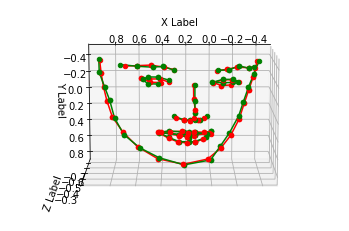

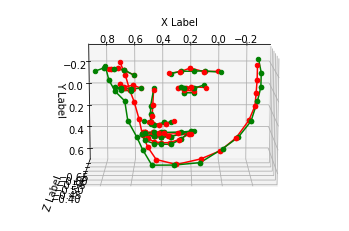

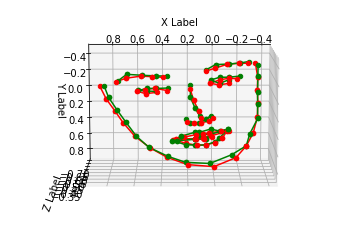

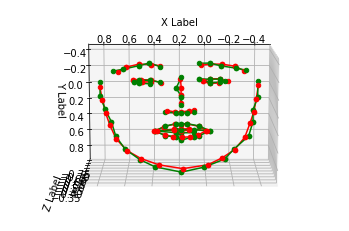

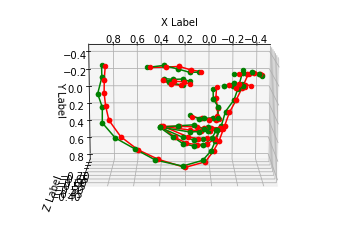

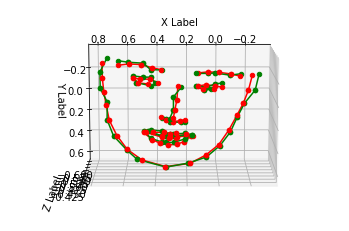

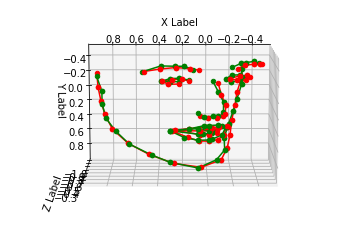

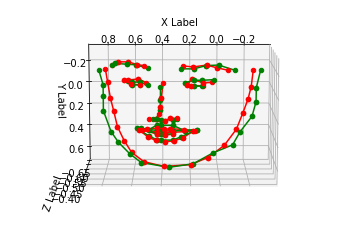

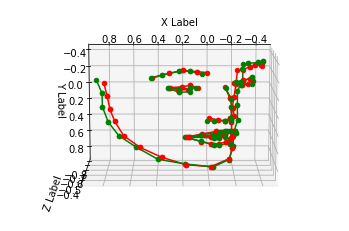

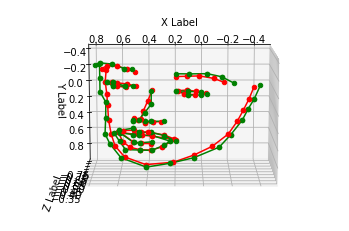

In [57]:
# model training 
for i in range(10):
    plot_3d(controller.epoch_n, key_pts[i], model_pts[i])

### Train

In [0]:
# load 2d pretrained model as init weight
# model.LM2D.load_state_dict(torch.load("/content/drive/My Drive/Models/lm2d.pt"))

In [0]:
model.to(device);
optimizer = optim.Adam(model.parameters(), lr=0.0001, eps=1e-7)

In [0]:
all_train_loss, all_val_loss = worker(n_epochs, train_loader, valid_loader, model, optimizer, criterion, early_stop, controller)

Epoch 15 EarlyStopping counter: 3 out of 3


### Training Graph

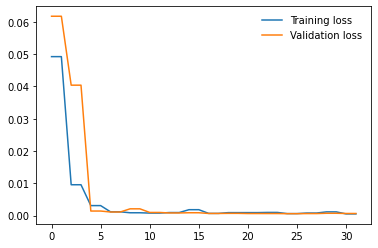

In [0]:
display_graph(all_train_loss, all_val_loss)

### Results

In [0]:
images, model_pts, key_pts = sample_output(test_loader, model)
for i in range(10):
    plot_3d(controller.epoch_n, key_pts[i], model_pts[i])